
#CSS 2 FINAL
Samuel Jin

******************
*******************

#Measuring political assassination data in Brazil on the municipality level from 2001-2017




*The dataset has been acquired by Mariana Carvalho, a PhD candidate at UCSD's Political Science Department. She is currently doing research on the political economy of Brazil; more specifically, the causal factors of political assassinations on the municipal level. My data science research project will aim to analyze the dataset she has collected, and provide data-driven insights on the causal factors of political assassinations.*
 


*******************
*******************
# **Libraries**

In [1]:
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import io
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
pd.options.display.float_format = '{:.2f}'.format # gets rid of scientific notation

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*******************
*******************
# **Getting data**

- Loads political assassination csv.
- Removes duplicate data, and subsets data to include years 2001-2017.
- Engineering the data, creating latent variables to control for confounding variable of municipality population such as the number of death per hundred thousand people and the ratio of effective local councilor candidates and mayoral candidates. 
- Electoral competition will be one of the main independent variables. 
- My hypothesis is that the ratio of effective candidates for local council and mayoral elections will be positively correlated with political
assassinations. I believe this because the more competetive an election is, bad actors such as corrupt politicians or local gangs will have a greater incentive to resort to violence to achieve their political motivations.

In [2]:
import pyreadstat
from google.colab import drive # Code for acquiring data
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

filename = 'data_assassinations_munic-year.csv'
data = pd.read_csv(filename) # removes extra index columns
dtafile = 'part_gov_mensais.dta' # oil royalities data 
#oil, meta = pyreadstat.read_dta(dtafile) #  loading stata file 
#oil = oil.drop(['mes'], axis=1) # drop unncesary columns
#oil = oil.drop(['ano'], axis=1)
#oil['id_IBGE_7'] = oil['cod_munic'] # standardizing identical variables
data = data[(data["year"] > 2000) & (data["year"] < 2018)] # removes two years which has 0 death data, must be data collection mistake
data['ratio_of_effective_cand_councilors'] = (data['eff_n_cand_councilor']/data['n_cand_councilor']) # ratio of effective counc candidates over total candidates
data['ratio_of_effective_cand_mayors'] = (data['eff_n_cand_mayor']/data['n_cand_mayor']) # ratio of effective mayoral candidates over total candidates
data['population_per_hundred_thousand'] = (data['pop_munic']/100000) # will later remove this 
data['death_per_hundred_thousand_pop'] = (data['death']/data['population_per_hundred_thousand'])  # death per 100,000 population, controls for population
data = data.drop(['population_per_hundred_thousand'], axis=1) # removing unnecesary column

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


***************
***************
# **Feature Engineering**

- Decided to add feature engineering early to have more relevant data visualizations and preliminary descriptive statistics.

**Outliers** 

- I will be allowing outlier data since I cannot afford to remove one instance of 26 deaths in a municipality despite the average being around 0; these outlier data points are important points of analysis and should be considered to use in hypothetical public policy decisions. There are outliers since some municipalities are much more populated than others. This population variable would result in many outliers such as effective number of local council candidates and political deaths. In essence, every observation no matter how big or small is valuable in this research.

**Dummy Variables** 

- I will not be creating any dummy variables because I do not have many categorical variables to code. I am mostly interested in municipalties and cannot create 5000+ seperate columns for each. 

**Missing values** 

- There are roughly 10,000 missing values in the 105,000 thousand observation data frame. If I were to make all missing values the median value, this would decrease variation and make the distribution more uniform. It would be detrimental to our analysis if all of the missing values were from a certain municipality or time frame. That is why I decided to remove years 2001 and 2018. Those years had 0 total deaths which shows flaws in data collection. Since my data appears to have random missing values and does not seem to have a systematic error in data collection besides the two excluded years, I will be dropping all of the missing data values.

**Duplicate Data**
- I have decided to remove all duplicate data. I understand the risk of inflating or deflating the data by doing this, but I do not believe my data would be significantly altered due to this decision. I believe a more accurate model would be created if this problem was removed entirely. 

In [3]:
any(data.duplicated()) # shows duplicates
data[data.duplicated(keep=False)]
data = data.drop_duplicates(ignore_index=True) # INDEXES
data.shape

(94690, 15)

In [4]:
data = data.dropna() # dropna will drop missing data; I believe it is okay since I have over 100,000 rows-- and the data appears to be randomly missing. 
data.info

<bound method DataFrame.info of        id_IBGE_7  ... death_per_hundred_thousand_pop
0        1100015  ...                           0.00
1        1100064  ...                           0.00
2        1101492  ...                           0.00
3        1101302  ...                           0.00
4        1101807  ...                           0.00
...          ...  ...                            ...
94668    5221601  ...                           0.00
94669    5208103  ...                           0.00
94670    5214606  ...                           0.00
94671    5205471  ...                           0.00
94672    5213806  ...                           0.00

[94202 rows x 15 columns]>

The first 5 observations of the political assassination dataset and the following columns. 

In [5]:
data.head()

,id_IBGE_7,municipality,id_state,year,year_census,death,n_cand_mayor,n_cand_councilor,n_cand_total,eff_n_cand_mayor,eff_n_cand_councilor,pop_munic,ratio_of_effective_cand_councilors,ratio_of_effective_cand_mayors,death_per_hundred_thousand_pop
0,1100015,Alta Floresta D'Oeste,11,2001,2000,0,4.00,59.00,63.00,2.96,37.90,26919.00,0.64,0.74,0.00
1,1100064,Colorado do Oeste,11,2001,2000,0,4.00,70.00,74.00,2.85,39.59,21421.00,0.57,0.71,0.00
2,1101492,SÃ£o Francisco do GuaporÃ©,11,2001,2000,0,3.00,91.00,94.00,1.56,55.32,11963.00,0.61,0.52,0.00
3,1101302,Mirante da Serra,11,2001,2000,0,2.00,64.00,66.00,1.92,43.68,13306.00,0.68,0.96,0.00
4,1101807,Vale do ParaÃ­so,11,2001,2000,0,2.00,48.00,50.00,1.82,32.71,9958.00,0.68,0.91,0.00


**Descriptive statistics for the political assassination data set.**


---
- 94202 unique observations of political violence on municipality.

*Population*
- We see the population variable has many outliers, 800 being the lowest for a municipality and 12106920 being the highest. Some cities such as Rio De Je Nairo are located in metropolitan areas while others are more underdeveloped and rural. 

*Political Deaths*
- .02 is the average amount of political deaths. This number ranges from 0-4, with 0 being the most frequent by far. 

*Political death per hundred thousand population*
- On average, there are 14 political assassinations per 100,000 population.
- Rarely does political violence result in a death, we see the highest is an instance where there were 60 political deaths per 100,000 population. 

*Effective number of political candidates for local council and mayoral office*
- The average ammount of effective number political candidates for local council is 32.28 and the average ammount of effective number of political candidates for mayor is 2.12. 
- The number of candidates for mayor and local council candidates are harder to scale, this is why I create a latent variable of effective candidates over total candidates.
- After creating the latent variables, we see the average ratio of effective number of local councilor candidates is .57 and .84 for mayoral candidates. 

In [6]:
data.describe()

,id_IBGE_7,id_state,year,year_census,death,n_cand_mayor,n_cand_councilor,n_cand_total,eff_n_cand_mayor,eff_n_cand_councilor,pop_munic,ratio_of_effective_cand_councilors,ratio_of_effective_cand_mayors,death_per_hundred_thousand_pop
count,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00,94202.00
mean,3252383.13,32.37,2009.00,2004.71,0.02,2.67,65.89,68.56,2.12,32.28,33866.31,0.57,0.84,0.14
std,983714.32,9.82,4.90,4.99,0.16,1.10,68.73,69.39,0.56,20.35,200744.33,0.13,0.17,1.55
min,1100015.00,11.00,2001.00,2000.00,0.00,1.00,9.00,10.00,1.00,5.59,800.00,0.08,0.18,0.00
25%,2512077.00,25.00,2005.00,2000.00,0.00,2.00,32.00,34.00,1.93,20.04,5240.00,0.48,0.71,0.00
50%,3146206.00,31.00,2009.00,2000.00,0.00,2.00,47.00,50.00,2.00,26.57,11023.00,0.57,0.93,0.00
75%,4118907.00,41.00,2013.00,2010.00,0.00,3.00,75.00,78.00,2.28,37.23,23436.75,0.66,0.99,0.00
max,5222302.00,52.00,2017.00,2010.00,4.00,15.00,1597.00,1605.00,6.70,294.08,12106920.00,0.99,1.00,60.02


First 5 observations of the political assassination data set.

In [7]:
data.head()

,id_IBGE_7,municipality,id_state,year,year_census,death,n_cand_mayor,n_cand_councilor,n_cand_total,eff_n_cand_mayor,eff_n_cand_councilor,pop_munic,ratio_of_effective_cand_councilors,ratio_of_effective_cand_mayors,death_per_hundred_thousand_pop
0,1100015,Alta Floresta D'Oeste,11,2001,2000,0,4.00,59.00,63.00,2.96,37.90,26919.00,0.64,0.74,0.00
1,1100064,Colorado do Oeste,11,2001,2000,0,4.00,70.00,74.00,2.85,39.59,21421.00,0.57,0.71,0.00
2,1101492,SÃ£o Francisco do GuaporÃ©,11,2001,2000,0,3.00,91.00,94.00,1.56,55.32,11963.00,0.61,0.52,0.00
3,1101302,Mirante da Serra,11,2001,2000,0,2.00,64.00,66.00,1.92,43.68,13306.00,0.68,0.96,0.00
4,1101807,Vale do ParaÃ­so,11,2001,2000,0,2.00,48.00,50.00,1.82,32.71,9958.00,0.68,0.91,0.00


Shows general information for political assassination data such as variables, non-null count, and the type of each variable.

In [8]:
print(data.info()) # Show data.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94202 entries, 0 to 94672
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id_IBGE_7                           94202 non-null  int64  
 1   municipality                        94202 non-null  object 
 2   id_state                            94202 non-null  int64  
 3   year                                94202 non-null  int64  
 4   year_census                         94202 non-null  int64  
 5   death                               94202 non-null  int64  
 6   n_cand_mayor                        94202 non-null  float64
 7   n_cand_councilor                    94202 non-null  float64
 8   n_cand_total                        94202 non-null  float64
 9   eff_n_cand_mayor                    94202 non-null  float64
 10  eff_n_cand_councilor                94202 non-null  float64
 11  pop_munic                           94202

***************
***************
# **Data Visualizations**


Total political assassinations over year 
- There is a positive correlation with these two variables. 
- From 2001-2014, there was a steady increase and from 2014-2017, there was a significant increase.  

---------------------------------------


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


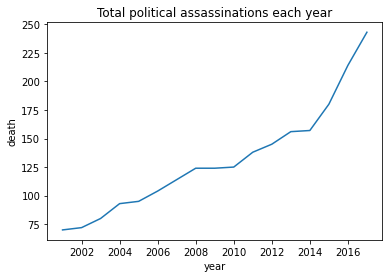

In [9]:
years_sum_death=data.groupby('year')['death'].sum().nlargest(19) # total political assasinations by year
years_sum_death = pd.DataFrame(years_sum_death)
years_sum_death.reset_index(drop=True, inplace=True)
years_sum_death['year'] = data['year'].unique() 
years_sum_death["year"] = years_sum_death["year"].tolist()[::-1]
print('---------------------------------------')
ax = sns.lineplot(years_sum_death['year'],years_sum_death['death'])
ax.set_title('Total political assassinations each year');


Percent of political violence resulting in death 
- There is a positive correlation with these two variables. 
- There has been a growing trend of political violence resulting in deaths over the years. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


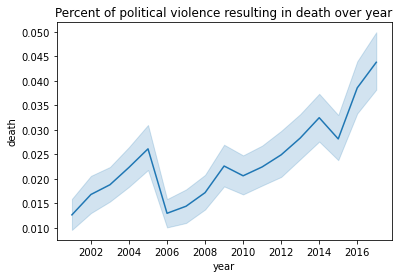

In [10]:
ax = sns.lineplot(data['year'],data['death']) # year over death
ax.set_title('Percent of political violence resulting in death over year');

Histogram of the political assassinations
- This distribution shows that the ammount of political violence recorded usually does not result in a death. It is very rare that a political assassination occurs in each case of political violence; the political deaths for 2, 3 and 4 are so low that it cannot be visualized on the histogram.

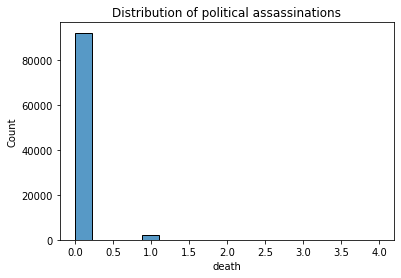

In [11]:
ax = sns.histplot(data=data, x="death") # 0 deaths still indicates political violence 
ax.set_title('Distribution of political assassinations'); # 2-113 deaths, 3-10 deaths, 4-2 deaths 

Histogram of political assassinations per hundred thousand population
- This distribution shows a similiar resemblance towards the histogram above. Even when controlling for capita, we see that the political assassinations are quite rare and are mostly fall within 0-10 political assassinations per hundred thousand population, with one outlier at 60 deaths per hundred thousand population.



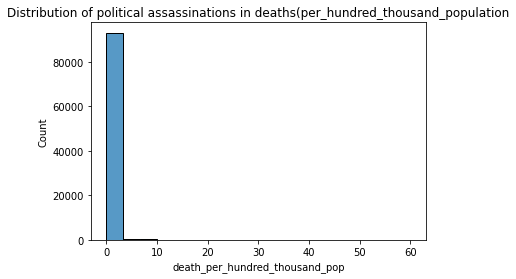

In [12]:
ax = sns.histplot(data=data, x="death_per_hundred_thousand_pop") # 
ax.set_title('Distribution of political assassinations in deaths(per_hundred_thousand_population'); # outliers such as a 60 can't be seen

Double Histogram of the amount of effective councilors and mayoral candidates
- The ammount of effective mayoral candidates is expected to be much lower than the number of effective local council candidates. This is because the structure of government usually allows for one mayor and multiple local council members

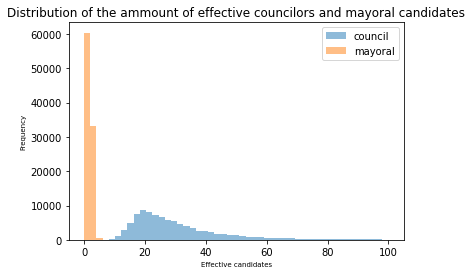

In [13]:
# double histogram on the ratio of effective candidates
bins = np.linspace(0,100)
pyplot.hist(data['eff_n_cand_councilor'], bins, alpha=0.5, label='council')
pyplot.hist(data['eff_n_cand_mayor'], bins, alpha=0.5, label='mayoral')
pyplot.title('Distribution of the ammount of effective councilors and mayoral candidates')
pyplot.legend(loc='upper right')
pyplot.ylabel('Frequency',fontsize=7)
pyplot.xlabel('Effective candidates',fontsize=7)
pyplot.show() # visualization 5

Double Histogram on the ratio of effective councilors and mayoral candidates over total candidates
- This double histogram controls for the size of each municipality and will provide a better illustration of the competetiveness of each local election. 
- We find that the mayoral elections have a much higher ratio of effective candidates, but that is because there are usually 2 mayoral candidates. 
- We find that there are usually 55-60% of effective local council candidates over total council candidates. 

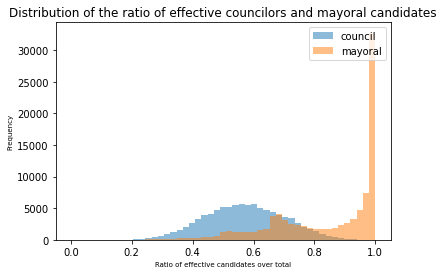

In [14]:
# double histogram on the ratio of effective candidates for the local council and mayoral election. 
bins = np.linspace(0,1)
pyplot.hist(data['ratio_of_effective_cand_councilors'], bins, alpha=0.5, label='council')
pyplot.hist(data['ratio_of_effective_cand_mayors'], bins, alpha=0.5, label='mayoral')
pyplot.title('Distribution of the ratio of effective councilors and mayoral candidates')
pyplot.ylabel('Frequency',fontsize=7)
pyplot.xlabel('Ratio of effective candidates over total',fontsize=7)
pyplot.legend(loc='upper right')
pyplot.show() # visualization 6

5 municipalities with the highest ammount of political assassinations

top five municipatlies with highest political assassinations per hundred thousand population: municipality
Rio de Janeiro          26
Nova IguaÃ§u            14
Duque de Caxias         13
SÃ£o JoÃ£o de Meriti    13
Belford Roxo            12
Name: death, dtype: int64


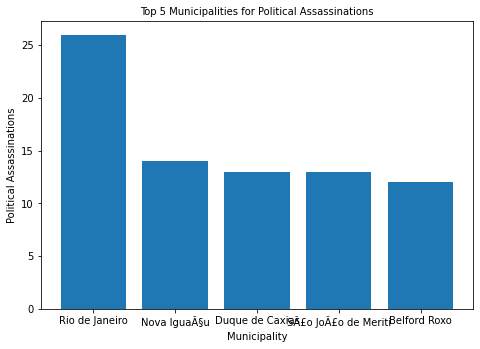

In [15]:
top_five_mun =data.groupby('municipality')['death'].sum().nlargest(5) # top 5 munic with highest political assasinations
print('top five municipatlies with highest political assassinations per hundred thousand population:', top_five_mun)

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
x = ['Rio de Janeiro', 'Nova IguaÃ§u', 'Duque de Caxias', 'SÃ£o JoÃ£o de Meriti', 'Belford Roxo']
y = [26,14,13,13,12]
ax.bar(x,y)
ax.set_ylabel('Political Assassinations', fontsize = 10) # bar plot of data mentioned above 
ax.set_xlabel('Municipality', fontsize = 10)
ax.set_title('Top 5 Municipalities for Political Assassinations', fontsize = 10)
plt.show()

5 municipalities with the highest ammount of political assassinations per hundred thousand population

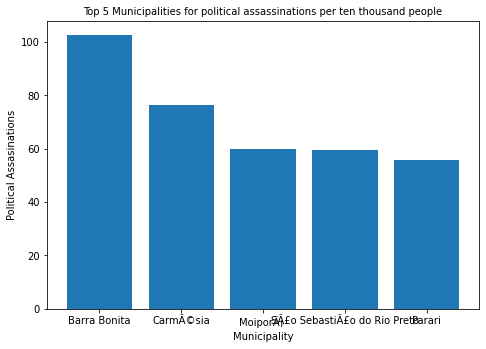

In [16]:
fig = plt.figure() 
ax = fig.add_axes([0,0,1,1])
x = ['Barra Bonita', 'CarmÃ©sia', 'MoiporÃ¡ ', 'SÃ£o SebastiÃ£o do Rio Preto', 'Parari'] # top 5 politcal assasinations per hundred thousand population
y = [102.74,76.28,60.02,59.70,55.71]
ax.bar(x,y)
ax.set_ylabel('Political Assasinations', fontsize = 10)
ax.set_xlabel('Municipality', fontsize = 10)
ax.set_title('Top 5 Municipalities for political assassinations per ten thousand people', fontsize = 10)
plt.show()

Start command for importing geobr library for spatial analysis of Brazil

In [17]:
pip install geobr

Preparing data for heatmaps
- merging municipality and political assasination data set 
- merging dataset of total political deaths with municipality data set

In [18]:
import geobr # relevant libraries to import after above pip command
from geobr import read_municipality

# creating new heat map df
mun_death =data.groupby('municipality')['death'].sum().nlargest(6000) # top 5 munip with highest political assasinations
rand_col =data.groupby('id_IBGE_7')['death'].sum().nlargest(6000) # top 5 munip with highest political assasinations
rand_col = pd.DataFrame(rand_col)
mun_death =data.groupby('id_IBGE_7')['death'].sum().nlargest(6000) # top 5 munip with highest political assasinations
map_death =data.groupby('id_IBGE_7')['death'].sum().nlargest(6000) # top 5 munip with highest political assasinations
mun_death = pd.DataFrame(mun_death)
map_death = pd.DataFrame(map_death)
map_death.reset_index(drop=True, inplace=True)
map_death['id_IBGE_7'] = data['id_IBGE_7'].unique() 
map_death.head()

pop = data.groupby('municipality')['pop_munic'].unique() # top 5 munip with highest political assasinations

# merging data sets for heatmaps 
mun = read_municipality(code_muni="all", year=2017)
mun_heat_map = mun.merge(data, how="left", left_on="code_muni", right_on= "id_IBGE_7")
map_death = mun.merge(map_death, how="left", left_on="code_muni", right_on= "id_IBGE_7")

In [19]:
# death per capita(in hundred thousand pop) heatmap
death_per_cap =data.groupby('id_IBGE_7')['death_per_hundred_thousand_pop'].sum().nlargest(6000) # top 5 munip with highest political assasinations
death_per_cap = pd.DataFrame(death_per_cap)
death_per_cap.reset_index(drop=True, inplace=True)
death_per_cap['id_IBGE_7'] = data['id_IBGE_7'].unique() 
death_per_cap = mun.merge(death_per_cap, how="left", left_on="code_muni", right_on= "id_IBGE_7")

In [20]:
death_per_cap.head()

,code_muni,name_muni,code_state,abbrev_state,geometry,death_per_hundred_thousand_pop,id_IBGE_7
0,1100015.00,Alta Floresta D'oeste,11,RO,"MULTIPOLYGON (((-62.19465 -11.82746, -62.18945...",102.74,1100015.00
1,1100023.00,Ariquemes,11,RO,"MULTIPOLYGON (((-62.53648 -9.73222, -62.52765 ...",34.21,1100023.00
2,1100031.00,Cabixi,11,RO,"MULTIPOLYGON (((-60.37075 -13.36363, -60.37134...",34.60,1100031.00
3,1100049.00,Cacoal,11,RO,"MULTIPOLYGON (((-61.00080 -11.29737, -61.00103...",43.92,1100049.00
4,1100056.00,Cerejeiras,11,RO,"MULTIPOLYGON (((-61.49976 -13.00525, -61.49426...",47.74,1100056.00


Heatmap of Brazilian municipalities and their number of political assasinations(per hundred thousand population)
- Shows the total number of political assassinations(per hundred thousand population) 
- The northwestern municipalities of Brazil have experienced the most political assassinations per capita

(-76.2481752903999, -26.57821821959995, -35.702328947549944, 7.222992030550023)

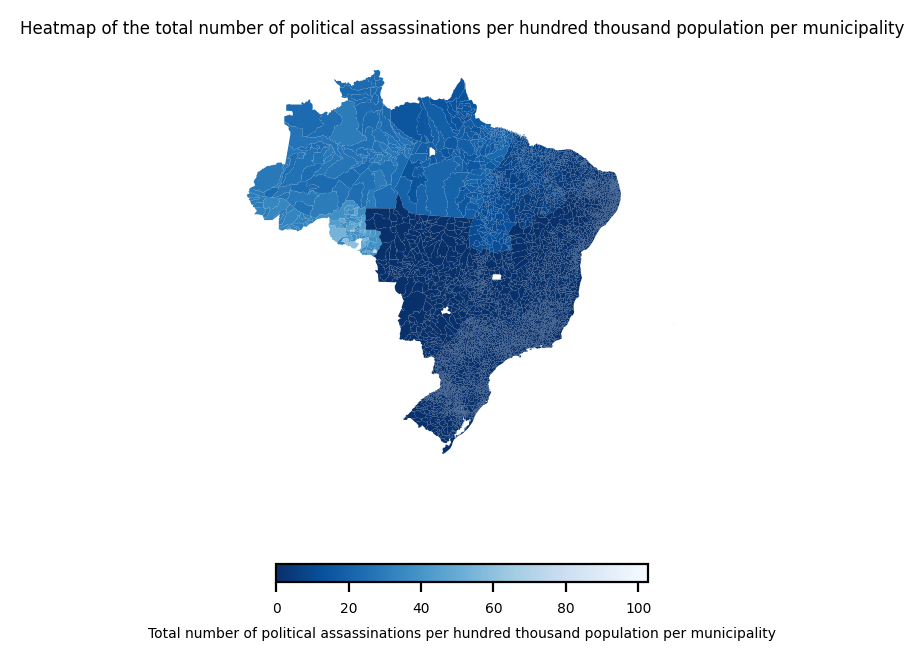

In [21]:
plt.rcParams.update({"font.size": 5}) 

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

death_per_cap.plot(
    column="death_per_hundred_thousand_pop",
    cmap="Blues_r",
    legend=True,
    legend_kwds={
        "label": "Total number of political assassinations per hundred thousand population per municipality",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
    ax=ax,
)

ax.set_title("Heatmap of the total number of political assassinations per hundred thousand population per municipality")
ax.axis("off")

Heatmap of total amount of deaths in each municipality
- The southern and eastern municipalities of Brazil have experienced, in total, less political assassinations compared to their northern and western counterparts. 
- There are a few random outliers which show municipalities with very high political assassinations

(-76.2481752903999, -26.57821821959995, -35.702328947549944, 7.222992030550023)

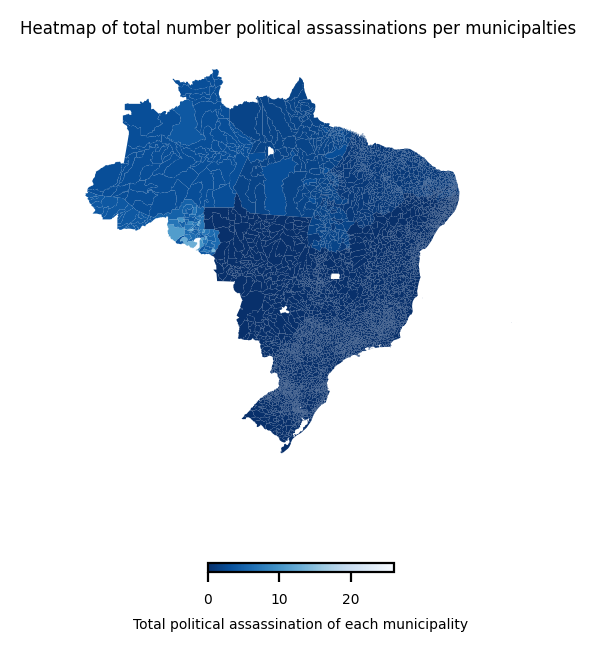

In [22]:
plt.rcParams.update({"font.size": 5}) 

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

map_death.plot(
    column="death",
    cmap="Blues_r",
    legend=True,
    legend_kwds={
        "label": "Total political assassination of each municipality",
        "orientation": "horizontal",
        "shrink": 0.3,
    },
    ax=ax,
)

ax.set_title("Heatmap of total number of political assassinations per municipality")
ax.axis("off")

Correlation Matrix of all variables 
- Very little correlations between death, death_in_hundred_thousand_pop and variables of interest: ratio of effective candidates for local council and mayoral elections

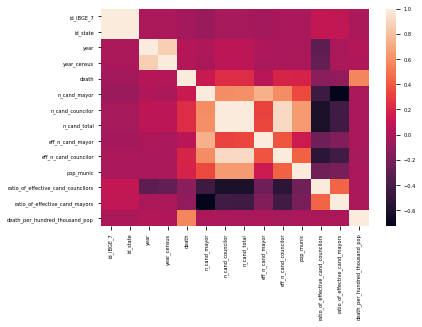

In [23]:
corr_matrix = data.loc[:,data.columns].corr()
#Using heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=False);

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94202 entries, 0 to 94672
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id_IBGE_7                           94202 non-null  int64  
 1   municipality                        94202 non-null  object 
 2   id_state                            94202 non-null  int64  
 3   year                                94202 non-null  int64  
 4   year_census                         94202 non-null  int64  
 5   death                               94202 non-null  int64  
 6   n_cand_mayor                        94202 non-null  float64
 7   n_cand_councilor                    94202 non-null  float64
 8   n_cand_total                        94202 non-null  float64
 9   eff_n_cand_mayor                    94202 non-null  float64
 10  eff_n_cand_councilor                94202 non-null  float64
 11  pop_munic                           94202

Linear regression of the ratio of the effective candidate councilors/mayors on political assassinations
- split testing and training data
- create linear regression
- fit the training data 
- calculating and printing variance for training and testing data
- get predicted y values
- create subplots of scatterplot and best fit line for training and testing data 



In [25]:
X = np.array(data['ratio_of_effective_cand_councilors']) # ratio_of_effective_cand_councilors
y = np.array(data['death']) # political assassination = death
X_train,X_test,y_train,y_test = train_test_split(X.reshape(len(X),1),y,random_state=1) # split data 

X_train= X_train.reshape(-1, 1)
X_test= X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)


model = LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)
  
print('Training R^2',model.score(X_train,y_train))
print('Testing R^2',model.score(X_test,y_test))
print('y = ',model.coef_[0],'*x + ',model.intercept_)
y_model = model.predict(X_test)# we need the predicted y values

Training R^2 0.017528778035288295
Testing R^2 0.012540490948256489
y =  [-0.16755495] *x +  [0.11961549]


Training Scatterplot of the ratio of effective local council candidates over number of deaths 
- We see that there seems to be a slight negative correlation, although it seems very insignificant


Text(0.5, 1.0, 'Training: Scatterplot of the ratio of effective local council candidates over death')

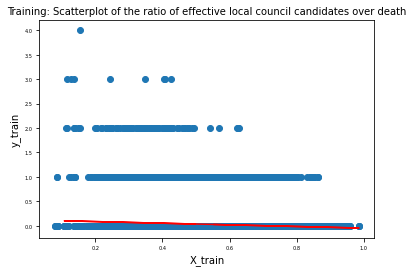

In [26]:
plt.scatter(X_train,y_train)
plt.plot(X_test,y_model,color='r')
plt.xlabel('X_train', fontsize= 10) 
plt.ylabel('y_train', fontsize = 10) 
plt.title("Training: Scatterplot of the ratio of effective local council candidates over death" ,fontsize= 10)

Testing Scatterplot of the ratio of effective local council candidates over number of deaths
- We see that there seems to be a slight negative correlation, although it seems very insignificant
- Very low variance in the testing data, may be better to conduct analysis as a causal inference problem with statistical analysis

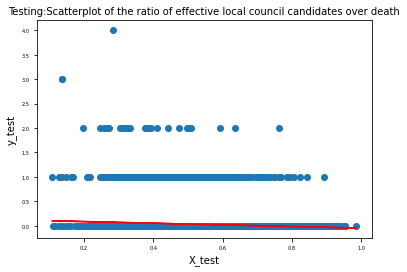

In [27]:
plt.scatter(X_test,y_test)
plt.plot(X_test,y_model,color='r')
plt.xlabel('X_test', fontsize= 10) 
plt.ylabel('y_test', fontsize= 10) 
plt.title("Testing:Scatterplot of the ratio of effective local council candidates over death", fontsize= 10)
plt.show()

Statistical Analysis on the ratio of effective local council candidates:
- Based on the OLS regression analysis results, we see that the p-value is below .05, therefore, the ratio of effective candidates is statistically significant while measuring political assassinations. When the ratio of the effective number of local councilers is 0, the number of deaths is .115. For every 1 unit increase in the ratio of effective local council candidates, the number of political deaths would decrease by -.161. This suggests that we reject the null hypothesis that the ratio of effective local council candidates has no effect on political assassinations.

In [28]:
sm_model = ols("death ~ ratio_of_effective_cand_councilors", data=data).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  death   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1566.
Date:                Wed, 09 Jun 2021   Prob (F-statistic):               0.00
Time:                        06:56:24   Log-Likelihood:                 38216.
No. Observations:               94202   AIC:                        -7.643e+04
Df Residuals:                   94200   BIC:                        -7.641e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [29]:
X = np.array(data['ratio_of_effective_cand_mayors'])
 # ratio_of_effective_cand_councilors
y = np.array(data['death']) # death_per_hundred_thousand_pop
X_train,X_test,y_train,y_test = train_test_split(X.reshape(len(X),1),y,random_state=1) # split data 

X_train= X_train.reshape(-1, 1)
X_test= X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)


model = LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)
  
print('Training R^2',model.score(X_train,y_train))
print('Testing R^2',model.score(X_test,y_test)) # the variance is so low possibly due to the amount of observations exceeding 100,000
print('y = ',model.coef_[0],'*x + ',model.intercept_)
y_model = model.predict(X_test)# we need the predicted y values

Training R^2 0.009771080570988855
Testing R^2 0.006818447129736782
y =  [-0.09471836] *x +  [0.10396014]


Training Scatterplot of the ratio of effective local mayoral candidates over death
- We see that there seems to be a slight negative correlation, although it seems very insignificant

Text(0.5, 1.0, 'Training: Scatterplot of the ratio of effective local mayoral candidates over death')

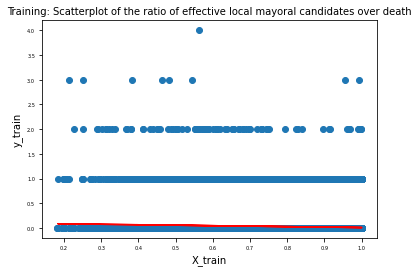

In [30]:
plt.scatter(X_train,y_train)
plt.plot(X_test,y_model,color='r')
plt.xlabel('X_train', fontsize = 10) 
plt.ylabel('y_train', fontsize = 10) 

plt.title("Training: Scatterplot of the ratio of effective local mayoral candidates over death", fontsize = 10)

Testing Scatterplot of the ratio of effective local mayoral candidates over death
- We see that there seems to be a slight negative correlation, although it seems very insignificant
- Very low variance in the testing data, might be better as a causal inference problem with statistical analysis

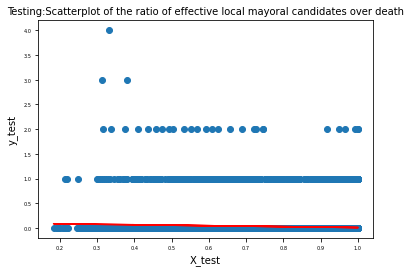

In [31]:
plt.scatter(X_test,y_test)
plt.plot(X_test,y_model,color='r')
plt.xlabel('X_test', fontsize = 10) 
plt.ylabel('y_test', fontsize = 10) 

plt.title("Testing:Scatterplot of the ratio of effective local mayoral candidates over death", fontsize = 10)
plt.show()

Statistical Analysis on the ratio of effective mayoral candidates:
- - Based on the OLS regression analysis results, we see that the p-value is below .05, therefore, the ratio of effective mayoral candidates is statistically significant while measuring political assassinations. When the ratio of the effective number of mayoral candidates is 0, the number of deaths is .1. For every 1 unit increase in the ratio of effective local mayoral candidates, the number of political deaths would decrease by -.09. This suggests that we reject the null hypothesis that the ratio of effective mayoral candidates has no effect on political assassinations.

In [32]:
sm_model = ols("death ~ ratio_of_effective_cand_mayors", data=data).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  death   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     862.9
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          8.08e-189
Time:                        06:56:25   Log-Likelihood:                 37869.
No. Observations:               94202   AIC:                        -7.573e+04
Df Residuals:                   94200   BIC:                        -7.571e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

***************
***************
# **Conclusions**

In my analysis, I found that there is a statistically signifiant relationship between the ratio of effective political candidates running for local council and mayor, and political assassinations. Although it is slim, this proves that my hypothesis was false. The greater the ratio of effective number of candidates for local council and the mayoral office, the less likely that a political assassination will occur. When there is less electoral competition in elections, there may be a greater incentive for bad actors such as corrupt politicians and gangs to use violence to consolidate political power. The more competetive the election, the more riskier and difficult it may be to leverage political violence. 